# Get extra text features for movies

In [2]:
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm

from globals import item_metadata_file, imdb_path, movielens_path

## Get text plots from public API

In [2]:
# load metadata
metadata = pd.read_hdf(item_metadata_file + '.h5', key='metadata')

In [3]:
metadata.index

Index(['tt0180093', 'tt0118694', 'tt0203009', 'tt0211915', 'tt0287467',
       'tt0167261', 'tt0317248', 'tt0266543', 'tt0325980', 'tt0335266',
       ...
       'tt1077368', 'tt2771200', 'tt0158622', 'tt0256009', 'tt0287717',
       'tt1655442', 'tt0335119', 'tt0360201', 'tt0430357', 'tt0422720'],
      dtype='object', length=1248)

In [4]:
plots = {}

In [5]:
def get_plot(imdbID, api_key='2438a607'):  # keys: a2ed3a33, 51ed9c6b, 2438a607
    url = f'http://www.omdbapi.com/?i={imdbID}&plot=full&apikey={api_key}'
    resp = requests.get(url=url)
    data = resp.json()
    if data['Response'] != 'False':
        return data['Plot']
    else:
        return ''

In [6]:
for imdbID in tqdm(metadata.index, total=len(metadata.index)):
    if imdbID not in plots or plots[imdbID] == '':
        plots[imdbID] = get_plot(imdbID)    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1248/1248 [07:14<00:00,  2.87it/s]


In [7]:
plots_df = pd.Series(plots)
plots_df

tt0180093    Sara Goldfarb (Ellen Burstyn) is a retired wid...
tt0118694    Set in Hong Kong, 1962, Chow Mo-Wan is a newsp...
tt0203009    The year is 1899, and Christian, a young Engli...
tt0211915    Amélie is a story about a girl named Amélie wh...
tt0287467    After a chance encounter at a theater, two men...
                                   ...                        
tt1655442                                                     
tt0335119                                                     
tt0360201                                                     
tt0430357                                                     
tt0422720                                                     
Length: 1248, dtype: object

<AxesSubplot:>

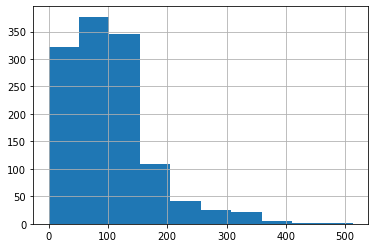

In [8]:
plots_df.apply(lambda x: len(x.split())).hist()

In [9]:
plots_df.to_csv('../data/text_plots.csv', header=None)

## Recover titles from IMDb

In [10]:
def load_imdb_titles(imdbIDs, usecols=('tconst', 'primaryTitle', 'genres', 'startYear')):
    df = pd.read_csv(imdb_path + 'title.basics.tsv', index_col='tconst', sep='\t', usecols=usecols, encoding='utf-8', keep_default_na=False, na_values=['\\N']).loc[imdbIDs]
    return df

df = load_imdb_titles(plots_df.index)

## Recover genome tags with their names

In [11]:
# load genome tags
def load_genome_tags(imdbIDs):
    # load genome tags supplied with movielens
    genometags = pd.read_csv(movielens_path + 'genome-scores.csv',
                             index_col='movieId',
                             usecols=['movieId', 'tagId', 'relevance'],
                             dtype={'movieId': np.int32, 'tagId': np.int32, 'relevance': np.float64})
    genometags = genometags.pivot_table('relevance', index='movieId', columns='tagId')
    
    genomenames = pd.read_csv(movielens_path + 'genome-tags.csv',
                             index_col='tagId',
                             dtype={'tagId': np.int32, 'tag': str})

    # change movieId to IMDb ID, link movieIds with imdbIds
    links = pd.read_csv(movielens_path + 'links.csv',
                        index_col='movieId',
                        usecols=['movieId', 'imdbId'],
                        dtype={'movieId': np.int32, 'imdbId': 'string'})
    genometags.index = 'tt' + genometags.index.map(links['imdbId'])
    genometags.rename({c: genomenames.loc[c]['tag'] for c in genometags.columns.tolist()}, inplace=True, axis=1)   # needed for concat to work later
    
    return genometags.loc[imdbIDs]

genome = load_genome_tags(plots_df.index)
genome

tagId,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
tt0180093,0.02175,0.01775,0.03025,0.05200,0.07750,0.07500,0.05050,0.26975,0.12500,0.03000,...,0.10325,0.01575,0.01550,0.17475,0.25575,0.18425,0.03525,0.01700,0.08775,0.02225
tt0118694,0.02125,0.01950,0.16625,0.15175,0.08775,0.07450,0.55700,0.16375,0.02200,0.13450,...,0.04550,0.02550,0.01675,0.11725,0.20100,0.12100,0.75800,0.01150,0.06575,0.01750
tt0203009,0.03450,0.02825,0.16725,0.14150,0.09850,0.08100,0.05225,0.12400,0.04000,0.19050,...,0.06550,0.03150,0.01500,0.26750,0.28400,0.11100,0.05575,0.01425,0.09600,0.01975
tt0211915,0.02375,0.01975,0.15650,0.10925,0.12925,0.12400,0.07450,0.22375,0.10375,0.08625,...,0.07375,0.02675,0.01950,0.11725,0.20550,0.11800,0.10725,0.01800,0.09475,0.02525
tt0287467,0.02175,0.02025,0.08400,0.15050,0.08175,0.06950,0.05475,0.21100,0.04650,0.06300,...,0.04725,0.02575,0.01950,0.11425,0.41250,0.18575,0.06400,0.02050,0.07325,0.01825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt1655442,0.02450,0.02250,0.15275,0.87575,0.86750,0.44625,0.11975,0.30575,0.08875,0.11525,...,0.07650,0.03175,0.01800,0.03850,0.17525,0.16225,0.03550,0.01525,0.09200,0.02150
tt0335119,0.03050,0.02850,0.68350,0.18500,0.18675,0.14000,0.11200,0.15125,0.02825,0.30375,...,0.10975,0.02025,0.01350,0.64350,0.28550,0.11225,0.06500,0.01400,0.08700,0.01825
tt0360201,0.03025,0.02950,0.06325,0.09225,0.04125,0.03150,0.02100,0.04900,0.03500,0.03025,...,0.05125,0.02275,0.00750,0.01775,0.16850,0.05225,0.02075,0.00750,0.10175,0.01900
tt0430357,0.08500,0.04000,0.02450,0.03275,0.04275,0.01175,0.01700,0.08825,0.06775,0.02275,...,0.07250,0.02025,0.01125,0.02125,0.18625,0.07475,0.03275,0.00925,0.09300,0.01575


### Convert numerical tags to categorical labels by applying a threshold

In [12]:
# source: https://stackoverflow.com/questions/38334296/reversing-one-hot-encoding-in-pandas
threshold = 0.7
genome['tags'] = ''                # new str col
for col_name in genome.columns:
    if col_name == 'tags': continue
    genome.loc[genome[col_name] >= threshold, 'tags'] = genome['tags'] + ' ' + col_name
genome['tags']

tt0180093     adaptation adapted from:book addiction atmosp...
tt0118694     adultery affectionate art house artistic atmo...
tt0203009     beautiful beautifully filmed cinematography c...
tt0211915     affectionate amazing cinematography artistic ...
tt0287467     almodovar beautifully filmed breathtaking cin...
                                   ...                        
tt1655442     1920s 1930s affectionate amazing photography ...
tt0335119     adaptation adapted from:book art artist artis...
tt0360201     chick flick cute! feel-good girlie movie happ...
tt0430357     action based on a tv show dialogue original r...
tt0422720     18th century based on a book cinematography c...
Name: tags, Length: 1248, dtype: object

<AxesSubplot:>

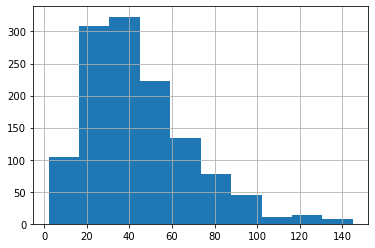

In [13]:
genome['tags'].apply(lambda x: len(x.split())).hist()

## Save everything into one dataframe

In [14]:
# Add text plot
df['plot'] = plots_df

# Add genome tags
df['tags'] = genome['tags']

In [15]:
df

,primaryTitle,startYear,genres,plot,tags
tt0180093,Requiem for a Dream,2000.0,Drama,Sara Goldfarb (Ellen Burstyn) is a retired wid...,adaptation adapted from:book addiction atmosp...
tt0118694,In the Mood for Love,2000.0,"Drama,Romance","Set in Hong Kong, 1962, Chow Mo-Wan is a newsp...",adultery affectionate art house artistic atmo...
tt0203009,Moulin Rouge!,2001.0,"Drama,Musical,Romance","The year is 1899, and Christian, a young Engli...",beautiful beautifully filmed cinematography c...
tt0211915,Amélie,2001.0,"Comedy,Romance",Amélie is a story about a girl named Amélie wh...,affectionate amazing cinematography artistic ...
tt0287467,Talk to Her,2002.0,"Drama,Mystery,Romance","After a chance encounter at a theater, two men...",almodovar beautifully filmed breathtaking cin...
...,...,...,...,...,...
tt1655442,The Artist,2011.0,"Comedy,Drama,Romance",,1920s 1930s affectionate amazing photography ...
tt0335119,Girl with a Pearl Earring,2003.0,"Biography,Drama,Romance",,adaptation adapted from:book art artist artis...
tt0360201,Wimbledon,2004.0,"Comedy,Romance,Sport",,chick flick cute! feel-good girlie movie happ...
tt0430357,Miami Vice,2006.0,"Action,Adventure,Crime",,action based on a tv show dialogue original r...


In [16]:
df.to_csv('../data/movie_info.csv')

## Explore

In [10]:
df = pd.read_csv('../data/movie_info.csv', index_col=0)
df['startYear'] = df['startYear'].astype(int)

In [11]:
df

,primaryTitle,startYear,genres,plot,tags
tt0180093,Requiem for a Dream,2000,Drama,Sara Goldfarb (Ellen Burstyn) is a retired wid...,adaptation adapted from:book addiction atmosp...
tt0118694,In the Mood for Love,2000,"Drama,Romance","Set in Hong Kong, 1962, Chow Mo-Wan is a newsp...",adultery affectionate art house artistic atmo...
tt0203009,Moulin Rouge!,2001,"Drama,Musical,Romance","The year is 1899, and Christian, a young Engli...",beautiful beautifully filmed cinematography c...
tt0211915,Amélie,2001,"Comedy,Romance",Amélie is a story about a girl named Amélie wh...,affectionate amazing cinematography artistic ...
tt0287467,Talk to Her,2002,"Drama,Mystery,Romance","After a chance encounter at a theater, two men...",almodovar beautifully filmed breathtaking cin...
...,...,...,...,...,...
tt1655442,The Artist,2011,"Comedy,Drama,Romance",NaN,1920s 1930s affectionate amazing photography ...
tt0335119,Girl with a Pearl Earring,2003,"Biography,Drama,Romance",NaN,adaptation adapted from:book art artist artis...
tt0360201,Wimbledon,2004,"Comedy,Romance,Sport",NaN,chick flick cute! feel-good girlie movie happ...
tt0430357,Miami Vice,2006,"Action,Adventure,Crime",NaN,action based on a tv show dialogue original r...


In [12]:
print(df[['primaryTitle', 'startYear', 'genres']].to_string())

                                                                                  primaryTitle  startYear                           genres
tt0180093                                                                  Requiem for a Dream       2000                            Drama
tt0118694                                                                 In the Mood for Love       2000                    Drama,Romance
tt0203009                                                                        Moulin Rouge!       2001            Drama,Musical,Romance
tt0211915                                                                               Amélie       2001                   Comedy,Romance
tt0287467                                                                          Talk to Her       2002            Drama,Mystery,Romance
tt0167261                                                The Lord of the Rings: The Two Towers       2002           Action,Adventure,Drama
tt0317248                  